# CSM148 Final Project

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Basic Statistics

In [50]:
hd=pd.read_csv("healthcare-dataset-stroke-data.csv")

In [20]:
hd.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
hd.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### null values

In [8]:
hd[hd.isnull().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [9]:
hd['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [10]:
len(hd.loc[hd['smoking_status']=="Unknown"])

1544

In [11]:
len(hd.loc[(hd['smoking_status']=="Unknown") & (hd['bmi'].isnull())])

61

In [12]:
print(hd['ever_married'].unique())
print(hd['work_type'].unique())
print(hd['Residence_type'].unique())

['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']


### histogram

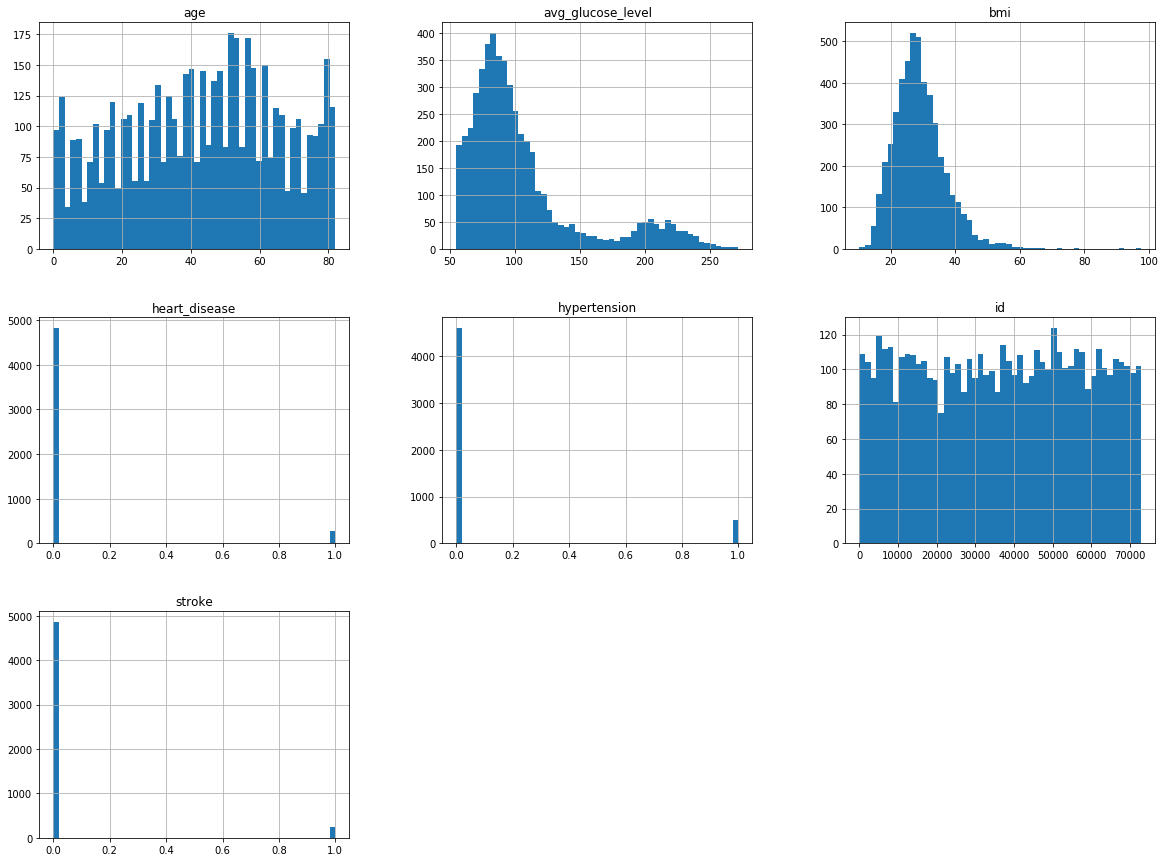

In [9]:
hd.hist(bins=50, figsize=(20,15))
plt.show()

0    4861
1     249
Name: stroke, dtype: int64

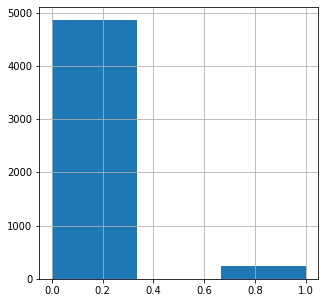

In [13]:
hd['stroke'].hist(bins=3, figsize=(5,5))
hd['stroke'].value_counts()

### Correlation

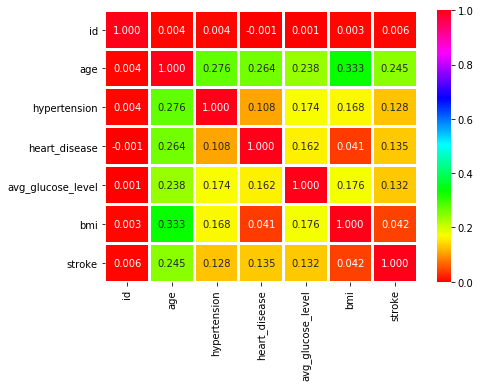

In [51]:
plt.figure(figsize=(7,5))
sns.heatmap(hd.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

## Part 2. Prepare the Data

In [52]:
hd=hd.drop(columns=['id'])

### Imputation

In [57]:
#store the non-null values here just in case
data0=hd.dropna()
data0_0=data0[data0['smoking_status']!="Unknown"]

In [64]:
# bmi Null value --> average
#hd['bmi'].mean()
hd=hd.fillna(hd['bmi'].mean())
hd.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### Augmentation

In [71]:
# bmi * glucose
hd['fat_bsugar']=hd['bmi']*hd['avg_glucose_level']
hd.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,fat_bsugar
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,8370.054000
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,5842.501436
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,3442.400000
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,5890.312000
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,4178.880000


### Pipeline

In [73]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
smoke=[]
smoke=le.fit_transform(hd['smoking_status'])
hd['smoking_status']=smoke

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

one_hot_features=['ever_married','gender','work_type','Residence_type']
numerical_features=['age','bmi','avg_glucose_level','hypertension','heart_disease','smoking_status','fat_bsugar']

features=numerical_features+one_hot_features

hd_processing_pipeline=ColumnTransformer([
    ('numerical',StandardScaler(), numerical_features),
    ('one_hot',OneHotEncoder(categories='auto'), one_hot_features)
])

X=hd_processing_pipeline.fit_transform(hd[features])

In [101]:
y=hd['stroke'].values

0    4861
1     249
Name: stroke, dtype: int64

In [103]:
#balance dataset
#data=hd.loc[hd['stroke'] == 0]

s0 = hd.stroke[hd.stroke.eq(0)].sample(250).index
s1 = hd.stroke[hd.stroke.eq(1)].sample(249).index 

df = hd.loc[s0.union(s1)]
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,fat_bsugar
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.600000,1,1,8370.054000
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.893237,2,1,5842.501436
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.500000,2,1,3442.400000
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.400000,3,1,5890.312000
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.000000,2,1,4178.880000
...,...,...,...,...,...,...,...,...,...,...,...,...
4934,Male,1.32,0,0,No,children,Rural,107.02,28.893237,0,0,3092.154214
4938,Female,62.00,0,0,Yes,Private,Urban,74.12,21.800000,1,0,1615.816000
5052,Female,6.00,0,0,No,children,Urban,91.05,22.100000,0,0,2012.205000
5053,Female,46.00,0,0,Yes,Govt_job,Urban,55.84,27.800000,2,0,1552.352000


In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

one_hot_features=['ever_married','gender','work_type','Residence_type']
numerical_features=['age','bmi','avg_glucose_level','hypertension','heart_disease','smoking_status','fat_bsugar']

features=numerical_features+one_hot_features

hd_processing_pipeline=ColumnTransformer([
    ('numerical',StandardScaler(), numerical_features),
    ('one_hot',OneHotEncoder(categories='auto'), one_hot_features)
])

X1=hd_processing_pipeline.fit_transform(df[features])
y1=df['stroke'].values

## Part 3. PCA

### Interpret feature importance

In [92]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

f_score, _ = f_regression(X,y)
discrete_features = np.zeros(X.shape[1])
discrete_features[0:len(hd_processing_pipeline.transformers[0][2])] = 1 # Numerical features are at the start
mi = mutual_info_regression(X, y, discrete_features=discrete_features.astype('bool_'))

print("Feature \t\t F-score \t\t MI")
for i,feature in enumerate(features): 
  print(f"{feature} \t\t {f_score[i]} \t\t {mi[i]}")

X_best = SelectKBest(f_regression,k=10).fit_transform(X, y)

Feature 		 F-score 		 MI
age 		 326.9165678586869 		 0.026662948367882855
bmi 		 7.7597756541479805 		 0.01062980359987531
avg_glucose_level 		 90.50386961378669 		 0.0
hypertension 		 84.95354215997183 		 0.0027149648095747825
heart_disease 		 94.69840601634587 		 0.005356715512613519
smoking_status 		 4.043033245970726 		 0.010113073346990298
fat_bsugar 		 81.09226477115658 		 0.016923846630360728
ever_married 		 60.66722965592213 		 0.0
gender 		 60.66722965591385 		 0.00022961730778447986
work_type 		 0.4162314391342801 		 0.0
Residence_type 		 0.4246250130154117 		 0.010432979703790757


In [97]:
X_best

array([[ 1.05143428e+00,  1.00123401e+00,  2.70637544e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.86070073e-01,  1.38466607e-15,  2.12155854e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.62639008e+00,  4.68577254e-01, -5.02830130e-03, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.63841511e-01,  2.21736316e-01, -5.11442636e-01, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.43796387e-01, -4.27845098e-01,  1.32825706e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.42048064e-02, -3.49895329e-01, -4.60867458e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### PCA dimensionality reduction

Text(0, 0.5, 'Total Explained Variance Ratio')

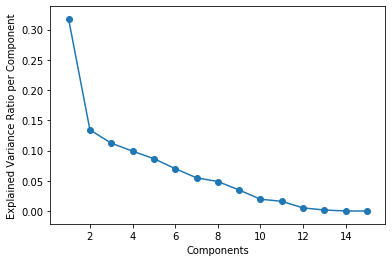

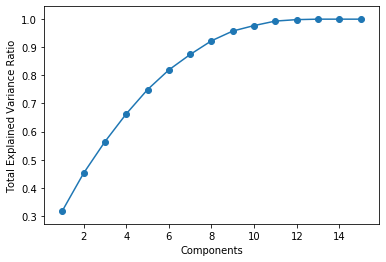

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pc = pca.fit_transform(X1)

plt.figure()
plt.plot(np.arange(15)+1,sorted(pca.explained_variance_ratio_,reverse=True))
plt.scatter(np.arange(15)+1,sorted(pca.explained_variance_ratio_,reverse=True),)
plt.xlabel("Components") 
plt.ylabel("Explained Variance Ratio per Component")

plt.figure()
plt.plot(np.arange(15)+1,np.cumsum(pca.explained_variance_ratio_))
plt.scatter(np.arange(15)+1,np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Total Explained Variance Ratio")

In [138]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pc = pca.fit_transform(X1)

### train-test split

In [105]:
train, test, target, target_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [139]:
#after pca
pca_train, pca_test, pca_target, pca_target_test = train_test_split(pc, y1, test_size=0.2, random_state=42)

## Part 4. Logistic Regression

Accuracy:    0.770000
Precision:   0.769231
Recall:      0.784314
F1 Score:    0.776699
Confusion Matrix: 
 [[37 12]
 [11 40]]


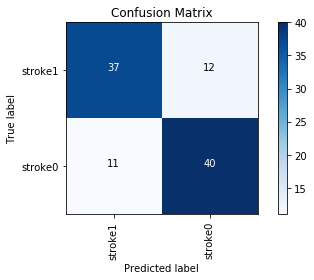

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

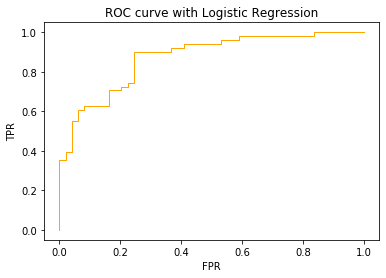

In [108]:
train_data_category = target
test_data_category = target_test

log_reg = LogisticRegression(penalty = 'l1', solver='liblinear')
log_reg.fit(train, target)
predicted = log_reg.predict(test)
score = log_reg.predict_proba(test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(test_data_category, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_data_category, predicted))
draw_confusion_matrix(target_test, predicted, ['stroke1', 'stroke0'])
fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(test_data_category, score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

Accuracy:    0.780000
Precision:   0.763636
Recall:      0.823529
F1 Score:    0.792453
Confusion Matrix: 
 [[36 13]
 [ 9 42]]


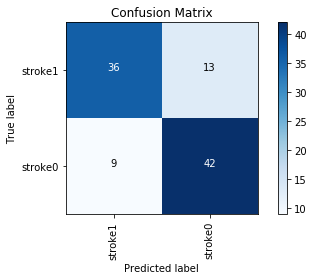

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

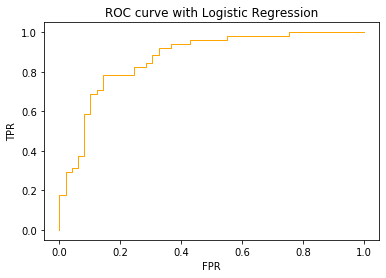

In [135]:
#pca n_components=5
pca_train_data_category = pca_target
pca_test_data_category = pca_target_test

log_reg = LogisticRegression(penalty = 'l1', solver='liblinear')
log_reg.fit(pca_train, pca_target)
pca_predicted = log_reg.predict(pca_test)
pca_score = log_reg.predict_proba(pca_test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(pca_test_data_category, pca_predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(pca_test_data_category, pca_predicted))
draw_confusion_matrix(pca_target_test, pca_predicted, ['stroke1', 'stroke0'])
fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(pca_test_data_category, pca_score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

Accuracy:    0.810000
Precision:   0.807692
Recall:      0.823529
F1 Score:    0.815534
Confusion Matrix: 
 [[39 10]
 [ 9 42]]


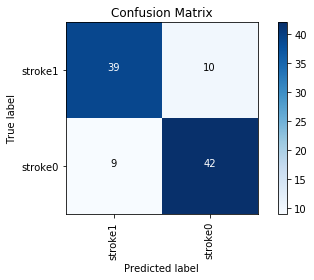

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

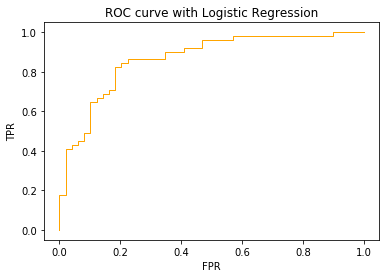

In [140]:
#7 features
pca_train_data_category = pca_target
pca_test_data_category = pca_target_test

log_reg = LogisticRegression(penalty = 'l1', solver='liblinear')
log_reg.fit(pca_train, pca_target)
pca_predicted = log_reg.predict(pca_test)
pca_score = log_reg.predict_proba(pca_test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(pca_test_data_category, pca_predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(pca_test_data_category, pca_predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(pca_test_data_category, pca_predicted))
draw_confusion_matrix(pca_target_test, pca_predicted, ['stroke1', 'stroke0'])
fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(pca_test_data_category, pca_score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

## Part 5. Ensemble (Random Forest)

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_fores

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_fores

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_fores

[[0.45614035087719296, 0.42606516290726815, 0.3884711779448622, 0.3784461152882206, 0.37092731829573933, 0.3609022556390977, 0.3508771929824561, 0.3483709273182958, 0.3408521303258145, 0.32832080200501257, 0.32832080200501257, 0.3208020050125313, 0.2957393483709273, 0.3007518796992481, 0.3007518796992481, 0.31829573934837097, 0.31328320802005016, 0.3157894736842105, 0.3157894736842105, 0.30325814536340856, 0.31328320802005016, 0.3107769423558897, 0.31829573934837097, 0.30827067669172936, 0.29824561403508776, 0.3057644110275689, 0.3107769423558897, 0.30325814536340856, 0.2957393483709273, 0.3107769423558897, 0.3057644110275689, 0.2957393483709273, 0.2957393483709273, 0.28822055137844615, 0.28822055137844615, 0.2907268170426065, 0.2957393483709273, 0.2907268170426065, 0.29323308270676696, 0.28320802005012535, 0.28320802005012535, 0.2807017543859649, 0.28320802005012535, 0.28822055137844615, 0.29824561403508776, 0.28822055137844615, 0.2807017543859649, 0.2957393483709273, 0.29323308270676

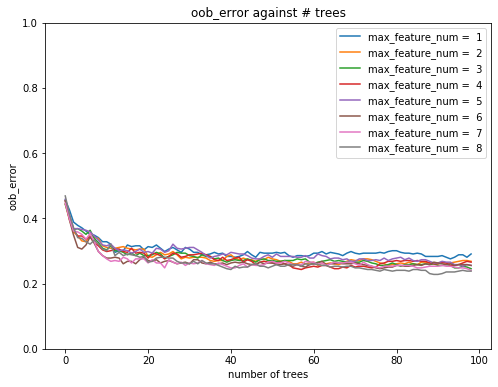

In [110]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

tree_num = np.arange(1, 100) #best tree:15
max_feature_num = np.arange(1,9) #best feature num:7

rmse = [[], [], [], [], [],[],[],[]]
oob_error = [[], [], [], [], [],[],[],[]]


for i in tree_num:
    for j in max_feature_num:
        rfr = RandomForestClassifier(n_estimators = i, max_features = j, max_depth = 20, bootstrap = True, oob_score = True, random_state = 42)
        rfr.fit(train, target)
      #  rfr_pred = cross_val_predict(rfr, X1, X_test, cv = 10)
        oob_error[j-1].append(1-rfr.oob_score_)
print (oob_error)


f = plt.figure() 
f.set_figwidth(8) 
f.set_figheight(6)
for i in range(8):
    plt.plot(oob_error[i], label = 'max_feature_num = % i' % max_feature_num[i])
plt.title('oob_error against # trees')
plt.xlabel('number of trees')
plt.ylabel('oob_error')
plt.ylim([0,1])
plt.legend(loc = 'best')
plt.show()

No handles with labels found to put in legend.


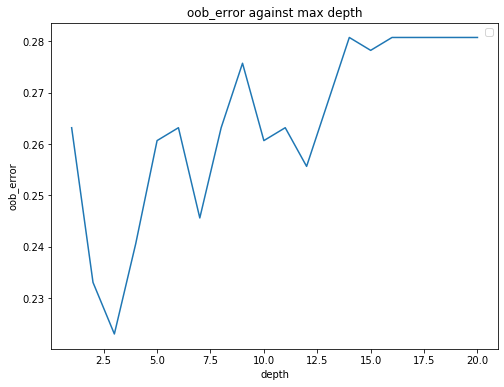

In [158]:
max_depth_num=np.arange(1,21)

rmse = np.zeros(20)
oob_error = np.zeros(20)

for i in max_depth_num:
    rf_d = RandomForestClassifier(n_estimators = 15, max_features = 7, max_depth = i, bootstrap = True, oob_score = True, random_state = 42)
    rf_d.fit(train, target)
    oob_error[i-1]=1-rf_d.oob_score_

f = plt.figure() 
f.set_figwidth(8) 
f.set_figheight(6)
plt.plot(max_depth_num,oob_error)
plt.title('oob_error against max depth')
plt.xlabel('depth')
plt.ylabel('oob_error')
plt.legend(loc = 'best')
plt.show()

Accuracy:    0.830000
Precision:   0.793103
Recall:      0.901961
F1 Score:    0.844037
Confusion Matrix: 
 [[37 12]
 [ 5 46]]


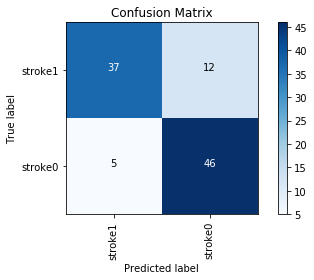

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

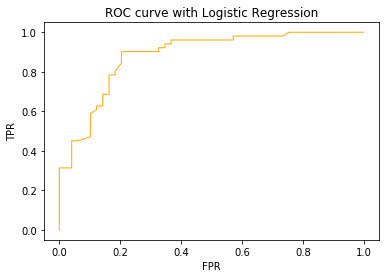

In [123]:
rf=RandomForestClassifier(n_estimators = 15, max_features = 7, max_depth = 3)

train_data_category = target
test_data_category = target_test

rf.fit(train, target)
predicted = rf.predict(test)
score = rf.predict_proba(test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(test_data_category, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_data_category, predicted))
draw_confusion_matrix(target_test, predicted, ['stroke1', 'stroke0'])
fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(test_data_category, score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

## Part 6. Neural Net Classifier

In [142]:
from sklearn.neural_network import MLPClassifier
parameters = {'solver': ['lbfgs'], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(1, 10)}
clf_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

In [143]:
clf_grid.fit(train,target)

print("Best score: %0.4f" % clf_grid.best_score_)
print("Using the following parameters:")
print(clf_grid.best_params_)

Best score: 0.7570
Using the following parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': 1, 'solver': 'lbfgs'}


Accuracy:    0.790000
Precision:   0.758621
Recall:      0.862745
F1 Score:    0.807339
Confusion Matrix: 
 [[35 14]
 [ 7 44]]


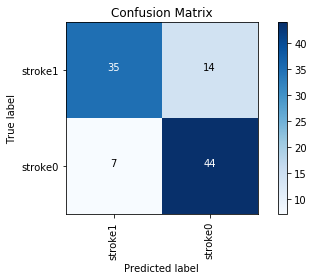

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

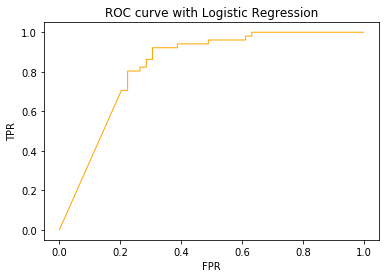

In [146]:
nn=MLPClassifier(alpha= 0.0001, hidden_layer_sizes= 1, solver='lbfgs')

train_data_category = target
test_data_category = target_test

nn.fit(train, target)
predicted = nn.predict(test)
score = nn.predict_proba(test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(test_data_category, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_data_category, predicted))
draw_confusion_matrix(target_test, predicted, ['stroke1', 'stroke0'])
fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(test_data_category, score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

## Part 7. Cross Validation

In [141]:
from sklearn.model_selection import KFold
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 

model_kfold = rf=RandomForestClassifier(n_estimators = 15, max_features = 7, max_depth = 3)

results_kfold = model_selection.cross_val_score(model_kfold, train, target, cv=kfold)

print("For an Random Forest our mean accuracy across folds is: %.2f%%" % (results_kfold.mean()*100.0)) 

For an Random Forest our mean accuracy across folds is: 75.93%


In [147]:
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 

model_kfold = MLPClassifier(alpha= 0.0001, hidden_layer_sizes= 1, solver='lbfgs')

results_kfold = model_selection.cross_val_score(model_kfold, train, target, cv=kfold)

print("For an Random Forest our mean accuracy across folds is: %.2f%%" % (results_kfold.mean()*100.0)) 

For an Random Forest our mean accuracy across folds is: 75.21%


/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Part 8. Custom Model (SVM)

Accuracy:    0.770000
Precision:   0.780000
Recall:      0.764706
F1 Score:    0.772277
Confusion Matrix: 
 [[38 11]
 [12 39]]


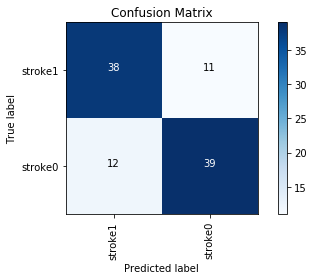

Logistic Model Performance Results:



Text(0, 0.5, 'TPR')

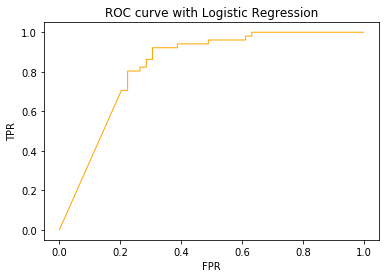

In [149]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=0.0001,random_state=42,max_iter=10000)

train_data_category = target
test_data_category = target_test

svm.fit(train, target)
predicted = svm.predict(test)
#score = svm.predict_proba(test)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(test_data_category, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_data_category, predicted))
draw_confusion_matrix(target_test, predicted, ['stroke1', 'stroke0'])
#fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(test_data_category, score)

print("Logistic Model Performance Results:\n")

pyplot.figure(1)
pyplot.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')

Accuracy:    0.820000
Precision:   0.789474
Recall:      0.882353
F1 Score:    0.833333
Confusion Matrix: 
 [[37 12]
 [ 6 45]]


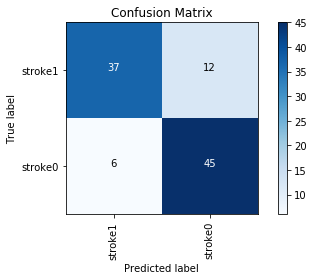

SVM Model Performance Results:



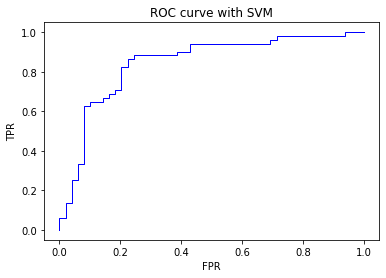

In [156]:
svm = SVC(probability=True)
svm.fit(train, target)
testing_result = svm.predict(test)
predicted = svm.predict(test)
score = svm.predict_proba(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(test_data_category, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(test_data_category, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_data_category, predicted))
draw_confusion_matrix(target_test, predicted, ['stroke1', 'stroke0'])

print("SVM Model Performance Results:\n")

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(target_test, score[:, 1], pos_label=1)

pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.title("ROC curve with SVM")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()